In [1]:
%config InlineBackend.figure_formats=['svg']
import numpy as np
import scipy
import scipy.sparse as sparse
import cvxpy as cp
import matplotlib.pyplot as plt
import only_prop_only_nuclear_norm as api
import time
import math
# For finite difference coefficients
import findiff

np.random.seed(0)

In [2]:
N_omega = 21
omega = np.linspace(-10, 10, N_omega)
delta_omega = np.abs(omega[1] - omega[0])
N_z = 6
z = np.linspace(0, 1*10**0, N_z)
delta_z = np.abs(z[1] - z[0])
green_fs = api.get_green_f(omega,z)
projection = np.zeros((N_omega, N_omega))
projections = []
sdr_def_constr = []
sdr_cst = []
tic = time.time()
for i in range(N_omega):
    for j in range(N_omega):
        proj_copy = projection.copy()
        proj_copy[i, j] = 1
        projections.append(sparse.csc_matrix(proj_copy))
        sdr_def_constr.append(api.sdr_def_constr(N_omega, N_z, sparse.csc_matrix(proj_copy)))
        if i == j:
            sdr_cst.append(2.)
        else:
            sdr_cst.append(0.)
print(time.time() - tic)

0.19487547874450684


In [3]:
beta_vec = np.exp(-np.linspace(omega[0], omega[-1], 2*N_omega - 1)**2/4.)#3*(np.random.random(2*N_omega - 1) - 0.5*np.ones(2*N_omega - 1))#
#np.array(list((0.1/decay_curve)*np.exp(np.linspace(0, position*delta_omega, position))) + list(0.1 + np.exp(-np.linspace(omega[position], omega[len(omega) - 1 - position], 2*N_omega - 1 - 2*position)**2)) + list((0.1/decay_curve)*np.exp(np.linspace(position*delta_omega, 0, position))))
beta = scipy.linalg.hankel(beta_vec[:N_omega], beta_vec[N_omega - 1:])
new_beta = beta/(np.sqrt(np.trace(beta@beta)))
# Try for n = 0.5
beta_weight = 2.145#9.9659#95.268#952.235#1.631#0.110747#663.61#1.30664#1.0868#0.02531#2.145#
delta_k = 1.j*np.diag(omega)
Q_plus = delta_k + beta_weight*new_beta
Q_minus = delta_k - beta_weight*new_beta
n = 0.25*np.trace((scipy.linalg.expm(Q_plus*z[-1]) - scipy.linalg.expm(Q_minus*z[-1])).conj().T@(scipy.linalg.expm(Q_plus*z[-1]) - scipy.linalg.expm(Q_minus*z[-1])))
W_plus = [(1/np.sqrt(n))*scipy.linalg.expm(Q_plus*z[i]) for i in range(1, N_z)]
W_minus = [(1/np.sqrt(n))*scipy.linalg.expm(Q_minus*z[i]) for i in range(1, N_z)]
X = np.vstack(W_plus + W_minus + [new_beta])
Y = np.vstack(W_plus + W_minus + [new_beta, np.eye(N_omega)])
full_rank = Y@Y.conj().T
n

(1.0000948401885161+0j)

In [100]:
np.trace(new_beta@new_beta)

1.0

In [101]:
# Verify the finite elements
green_f = api.get_green_f(omega, z[1:-1])
green_f.reverse()
first_term = scipy.linalg.expm(delta_k*z[-1]).conj().T
second_term = 0.5*delta_z*beta_weight*((np.sqrt(n))*new_beta@W_plus[-1].conj().T + scipy.linalg.expm(delta_k*z[-1]).conj().T@new_beta)
third_term = (np.sqrt(n))*delta_z*beta_weight*sum([green_f[i].conj().T@new_beta@W_plus[i].conj().T for i in range(len(green_f))])
approx = first_term + second_term + third_term

In [102]:
np.max(np.abs(np.real((1/np.sqrt(n))*approx - W_plus[-1].conj().T))), np.max(np.abs(np.imag((1/np.sqrt(n))*approx - W_plus[-1].conj().T)))

(0.0011093455792443169, 0.00023186623596768707)

In [103]:
# Verify the finite differences for plus
coeffs = findiff.coefficients(deriv = 1, offsets=list(np.arange(0, N_z)))["coefficients"]
j = 4
quad_plus = [full_rank[i*N_omega:(i + 1)*N_omega, j*N_omega:(j + 1)*N_omega] for i in range(N_z - 1)]
quad_pump_prop = full_rank[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, j*N_omega:(j + 1)*N_omega]
truth = (1/np.sqrt(n))*(delta_k@W_plus[j].conj().T + beta_weight*quad_pump_prop)
test = sum([(1/delta_z)*coeffs[i + 1]*quad_plus[i] for i in range(len(W_plus))]) + (coeffs[0]/(delta_z*np.sqrt(n)))*W_plus[j].conj().T

In [104]:
np.max(np.abs(np.real(truth - test))), np.max(np.abs(np.imag(truth - test)))

(0.00041700275456513225, 0.0002674106225155626)

In [84]:
proj = projections[0]
real_mat = []
imag_mat = []
for j in range(N_z - 1):
    quad_j_prop = sum([(1/delta_z)*coeffs[i + 1]*api.quad_proj(N_omega, N_z, j, i, proj) for i in range(len(coeffs) - 1)])
    quad_j_pump = (1/np.sqrt(n))*beta_weight*api.quad_proj(N_omega, N_z, j, 2*N_z - 2, proj)
    quad = quad_j_prop - quad_j_pump
    lin = (api.get_lin_matrices(N_omega=N_omega, N_z = N_z, proj = (coeffs[0]/(np.sqrt(n)*delta_z))*proj - (1/np.sqrt(n))*proj@delta_k)[j])
    real_mat.append(sparse.bmat([[0.5*(quad + quad.conj().T), 0.5*lin],
                                [0.5*lin.conj().T, sparse.csc_matrix((N_omega, N_omega))]]))
    imag_mat.append(sparse.bmat([[-0.5*1.j*(quad - quad.conj().T), -0.5*1.j*lin],
                                [0.5*1.j*lin.conj().T, sparse.csc_matrix((N_omega, N_omega))]]))

In [85]:
np.trace(real_mat[-1]@Y@Y.conj().T) + 1.j*np.trace(imag_mat[-1]@Y@Y.conj().T), np.trace(proj@(test - truth))

((0.013297361889385684+0.00785543392075816j),
 (0.013197014380303074-0.008028608901341272j))

In [105]:
# Verify the finite differences for minus
coeffs = findiff.coefficients(deriv = 1, offsets=list(np.arange(0, N_z)))["coefficients"]
j = 4
quad_minus = [full_rank[(N_z - 1 + i)*N_omega:(N_z - 1 + i + 1)*N_omega, (N_z - 1 + j)*N_omega:(N_z - 1 + j + 1)*N_omega] for i in range(N_z - 1)]
quad_pump_prop = full_rank[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, (N_z - 1 + j)*N_omega:(N_z - 1 + j + 1)*N_omega]
truth = (1/np.sqrt(n))*(delta_k@W_minus[j].conj().T - beta_weight*quad_pump_prop)
test = (sum([(1/delta_z)*coeffs[i + 1]*quad_minus[i] for i in range(len(W_minus))]) + (coeffs[0]/(delta_z*np.sqrt(n)))*np.eye(N_omega)@W_minus[j].conj().T)

In [106]:
np.max(np.abs(np.real(truth - test))), np.max(np.abs(np.imag(truth - test)))

(0.00041709867235617537, 0.0002673520025071596)

In [62]:
real_mat = []
imag_mat = []
for j in range(N_z - 1):
    quad_j_prop = sum([(1/delta_z)*coeffs[i + 1]*api.quad_proj(N_omega, N_z, N_z - 1 + j, N_z - 1 + i, proj) for i in range(len(coeffs) - 1)])
    quad_j_pump = (1/np.sqrt(n))*beta_weight*api.quad_proj(N_omega, N_z, N_z - 1 + j, 2*N_z - 2, proj)
    quad = quad_j_prop + quad_j_pump
    lin = (api.get_lin_matrices(N_omega=N_omega, N_z = N_z, proj = (coeffs[0]/(np.sqrt(n)*delta_z))*proj - (1/np.sqrt(n))*proj@delta_k)[N_z - 1 + j])
    real_mat.append(sparse.bmat([[0.5*(quad + quad.conj().T), 0.5*lin],
                                [0.5*lin.conj().T, sparse.csc_matrix((N_omega, N_omega))]]))
    imag_mat.append(sparse.bmat([[-0.5*1.j*(quad - quad.conj().T), -0.5*1.j*lin],
                                [0.5*1.j*lin.conj().T, sparse.csc_matrix((N_omega, N_omega))]]))

In [63]:
np.trace(real_mat[-1]@Y@Y.conj().T) + 1.j*np.trace(imag_mat[-1]@Y@Y.conj().T), np.trace(proj@(test - truth))

((-19.816577863343788+11.309101301177444j),
 (-19.816577863343795+11.309101301177442j))

In [ ]:
# Make sure to get the finite difference constraints right!!

In [87]:
# Errors on the approximation
real = [0.2514, 0.2229, 0.2181, 0.0512, 0.0280, 0.01815, 0.01283, 0.009593, 0.007462, 0.005979, 0.004902, 0.004095, 0.003473, 0.002984, 0.002592]
imag = [0.2110, 0.1542, 0.1463, 0.0345, 0.0189, 0.01223, 0.008649, 0.006467, 0.005031, 0.004031, 0.003305, 0.002760, 0.002341, 0.002011, 0.001747]

In [88]:
sum(scipy.linalg.svd((1/np.sqrt(n))*approx)[1]) - sum(scipy.linalg.svd(W_plus[-1])[1])

-0.0019853505703473218

purity:  1.2502435835764172


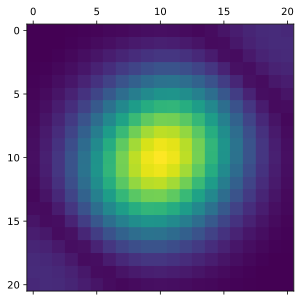

In [63]:
# JSA and purity
plt.matshow(np.abs((W_plus[-1] + W_minus[-1]).conj().T@(W_plus[-1] - W_minus[-1])))
print("purity: ", sum(0.5*scipy.linalg.svd(W_plus[-1] - W_minus[-1])[1]))

In [6]:
# Creates the matrix for the hermite basis superposition
max_order = 5
width = 4.
hermite_mat = api.get_hermite_polynom_mat(omega, max_order, width)

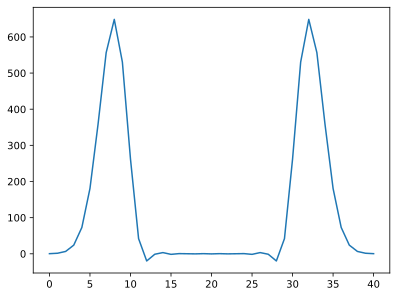

In [25]:
plt.plot(hermite_mat[-1])

In [5]:
# Generate constraints
n = 1.
beta_weight = 4.0#0.23#1.5#2.145
dynamics_constr = []
sympl_constr = []
pump_fix_constr = []
quad_symplect = []
gen_symplect = []
backwards_quad_fin_diff = []
central_fin_diff = []
# Changed the constraint to be tr(VV) = delta_omega**2
pump_power_constr = api.limit_pump_power(omega, N_z)
photon_end_nbr_constr = api.photon_nbr_constr(N_omega, N_z, n)
photon_prev_ineq_constr = api.photon_nbr_prev_points(N_omega, N_z)
pump_hankel_constr = api.constr_hankel_sdr(N_omega, N_z)
fixed_first_last_row = api.constr_first_last_row_pump(N_omega, N_z, new_beta, free_indices)
affine_ineq_pump = api.basic_affine_ineq_pump(N_omega, N_z, np.array(list(new_beta[0]) + list(new_beta[-1][1:])), 10**-6)
constr_left_decay, constr_right_decay = api.pump_exp_decay_constr(N_omega, N_z, "positive", "positive", 5, 20, max_ampli=0.01)
for i in range(len(projections)):
    real_sympl, imag_sympl = api.sympl_constr_sdr(N_omega, N_z, projections[i], n)
    real_fixed_pump, imag_fixed_pump = api.sdr_fixed_pump(N_omega, N_z, new_beta, projections[i])
    dynamics_constr += api.get_dynamics_mats(omega, z, beta_weight, n, projections[i])
    sympl_constr += real_sympl + imag_sympl
    quad_symplect += api.constr_lower_quadratic_prop_sympl(N_omega, N_z, projections[i]) + api.constr_upper_quadratic_prop_sympl(N_z, N_omega, projections[i])
    gen_symplect += api.constr_sympl_plus(N_z, N_omega, n, projections[i]) + api.constr_sympl_minus(N_z, N_omega, n, projections[i])
    pump_fix_constr += [imag_fixed_pump]#, real_fixed_pump]
    backwards_quad_fin_diff += api.backwards_fin_diff_quad_plus(N_omega, z, beta_weight, n, delta_k, projections[i]) + api.backwards_fin_diff_quad_minus(N_omega, z, beta_weight, n, delta_k, projections[i])
    central_fin_diff += list(api.central_finite_diff_affine(z, N_omega, beta_weight, n, delta_k, projections[i]))
constraints_list = dynamics_constr + sympl_constr + pump_hankel_constr + [photon_end_nbr_constr, pump_power_constr]  + quad_symplect + gen_symplect + pump_fix_constr + backwards_quad_fin_diff + central_fin_diff

In [10]:
[(np.trace(Y.conj().T@constraints_list[i]@Y), i) for i in range(len(constraints_list)) if np.real(np.trace(Y.conj().T@constraints_list[i]@Y)) > 10**-3]

[((0.0011094663564662072+9.389519035925227e-19j), 414),
 ((0.0011094663564662072+1.9962057596666677e-18j), 8414)]

In [5]:
# Get matrices to build objective function
left, right = api.obj_f_mat(N_omega, N_z)

In [6]:
# Set constraints to make the nuclear norm of U_+ and U_- less or equal that of the rank 1 problem
left_both = api.get_lin_matrices(N_z, N_omega, sparse.eye(N_omega))[2*N_z - 2]
left_both = sparse.vstack([sparse.csc_matrix((N_omega, N_omega)), left_both])
right_plus = api.get_lin_matrices(N_z, N_omega, sparse.eye(N_omega))[N_z - 2]
right_plus.resize((2*N_z*N_omega, N_omega))
right_minus =  api.get_lin_matrices(N_z, N_omega, sparse.eye(N_omega))[2*N_z - 3]
right_minus.resize((2*N_z*N_omega, N_omega))
# Try relaxing the constraint on high purity more to obtain solution with a hermite cutoff
epsilon = .01
cst_plus = (N_omega - 2)/np.sqrt(n) + 1 + np.sqrt(1 + 1/n) +  epsilon/2 + np.sqrt((epsilon**2)/4 + 1/n)
cst_minus = (N_omega - 2)/np.sqrt(n) - .995 + np.sqrt((.995)**2 + 1/n) + epsilon/2 + np.sqrt((epsilon**2)/4 + 1/n)
cst_plus, cst_minus, sum(scipy.linalg.svd((W_plus)[-1])[1]),sum(scipy.linalg.svd(W_minus[-1])[1])

((22.419029276324007+0j),
 (20.420498156084104+0j),
 21.851903857950237,
 21.074555367711046)

In [67]:
# Constraint on spectral norm of U_-?
max(0.5*scipy.linalg.svd(left_both.conj().T@Y@Y.conj().T@right_minus)[1]), max(0.5*scipy.linalg.svd(left_both.conj().T@Y@Y.conj().T@right_plus)[1]), 

(0.976088584167264, 0.967868713212357)

In [74]:
max(scipy.linalg.svd(W_plus[-1])[1]), np.sqrt(1/n), max(scipy.linalg.svd(U_plus[-1])[1])

(1.9357374264247145, (1.4795993003745025+0j), 1.4460310305110002)

In [75]:
max(scipy.linalg.svd(W_minus[-1])[1]), np.sqrt(1/n), max(scipy.linalg.svd(U_minus[-1])[1])

(1.9521771683345277, (1.4795993003745025+0j), 1.4460310305075028)

In [7]:
# Matrices to get the sum of U_+N and U_-N
left_sum_sing_val = api.get_lin_matrices(N_z, N_omega, sparse.eye(N_omega))[N_z - 2] + api.get_lin_matrices(N_z, N_omega, sparse.eye(N_omega))[2*N_z - 3]
left_sum_sing_val.resize((2*N_z*N_omega, N_omega))
right_sum_sing_val = api.get_lin_matrices(N_z, N_omega, sparse.eye(N_omega))[2*N_z - 2]
right_sum_sing_val = sparse.vstack([sparse.csc_matrix((N_omega, N_omega)), right_sum_sing_val])
cst_sum = N_omega*(1/n + 1)/(-1 + np.sqrt(1 + 1/n))

In [8]:
variable = cp.Variable(shape = (2*N_z*N_omega, 2*N_z*N_omega), hermitian = True)
hermite_coeff = cp.Variable(shape=(max_order,))
constraints = [variable >> 0]
constraints += [cp.real(cp.trace(sdr_def_constr[i]@variable)) == sdr_cst[i] for i in range(len(sdr_def_constr))]
constraints += [cp.real(cp.trace(constraints_list[i]@variable)) == 0 for i in range(len(constraints_list))]
constraints += [cp.real(cp.trace(photon_prev_ineq_constr[i]@variable)) >= 0 for i in range(len(photon_prev_ineq_constr))]
# Nuclear norm into SDP
# More dual constraints when using directly nuc norm
# Are you absolutely certain the constraint is enforeced comme il faut?
V_plus = cp.Variable(shape = (N_omega, N_omega), hermitian = True)
X_plus = cp.Variable(shape = (N_omega, N_omega), hermitian = True)
V_minus = cp.Variable(shape = (N_omega, N_omega), hermitian = True)
X_minus = cp.Variable(shape = (N_omega, N_omega), hermitian = True)
var_U_plus_dagger = left_both.conj().T@variable@right_plus
var_U_minus_dagger = left_both.conj().T@variable@right_minus
Q_plus = cp.vstack([cp.hstack([V_plus, var_U_plus_dagger]), cp.hstack([var_U_plus_dagger.conj().T, X_plus])])
Q_minus = cp.vstack([cp.hstack([V_minus, var_U_minus_dagger]), cp.hstack([var_U_minus_dagger.conj().T, X_minus])])
constraints.append(Q_plus >> 0)
constraints.append(Q_minus >> 0)
constraints.append(cp.real(cp.trace(V_plus + X_plus)) - 2*cst_plus == 0)
constraints.append(cp.real(cp.trace(V_minus + X_minus)) - 2*cst_minus == 0)
# Constraint on the pump itself
#left_first_pump, left_second_pump, right_first_pump, right_second_pump = api.isolate_vect_pump(N_omega, N_z)
#constraints.append(cp.real(cp.hstack([left_first_pump.conj().T@variable@right_first_pump, left_second_pump.conj().T@variable@right_second_pump])) == hermite_mat.T@hermite_coeff)
# Constraint to get set the pump within a margin of numerically optimal pump
#constraints += [cp.real(cp.trace(affine_ineq_pump[i]@variable)) <= 0 for i in range(len(affine_ineq_pump))]
problem = cp.Problem(cp.Minimize(cp.atoms.norm(left.conj().T@variable@right, "nuc")), constraints)

In [9]:
problem.solve(solver = cp.MOSEK, mosek_params = {"MSK_IPAR_NUM_THREADS":8, "MSK_IPAR_INTPNT_MAX_ITERATIONS":2000, "MSK_DPAR_INTPNT_CO_TOL_REL_GAP":10e-1, "MSK_DPAR_INTPNT_CO_TOL_MU_RED":10e-1}, verbose = True)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 08 07:09:54 PM: Your problem has 65268 variables, 99192 constraints, and 0 parameters.
(CVXPY) Jul 08 07:09:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 08 07:09:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 08 07:09:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 08 07:09:54 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 08 07:09:55 PM: Compiling problem (target solver=MOSE

0.21964424936623264

In [7]:
end_product = np.load("n_1_beta_weight_0_point_2.npy")
end_result_2 = np.load("n_1_bbeta_weight_0_point_25.npy")
eig_val = scipy.linalg.eigvalsh(end_result)
eig_val_2 = scipy.linalg.eigvalsh(end_result_2)

In [8]:
U_plus = [end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z - 1)]
U_minus = [end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (N_z - 1 + i)*N_omega:(N_z + i)*N_omega] for i in range(N_z - 1)]
VU_plus = [end_product[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z - 1)]
VU_minus = [end_product[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, (N_z - 1 + i)*N_omega:(N_z + i)*N_omega] for i in range(N_z - 1)]
quad_U_plus = [end_product[i*N_omega:(i + 1)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z - 1)]
quad_U_minus = [end_product[(N_z - 1 + i)*N_omega:(N_z + i)*N_omega, (N_z - 1 + i)*N_omega:(N_z + i)*N_omega] for i in range(N_z - 1)]
pump_U_plus = [end_product[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z - 1)]
pump_U_minus = [end_product[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, (N_z - 1 + i)*N_omega:(N_z - 1 + i + 1)*N_omega] for i in range(N_z - 1)]
opt_pump = end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega]

In [10]:
0.5*sum(scipy.linalg.svd(U_plus[-1] - U_minus[-1])[1])

0.36727012096982053

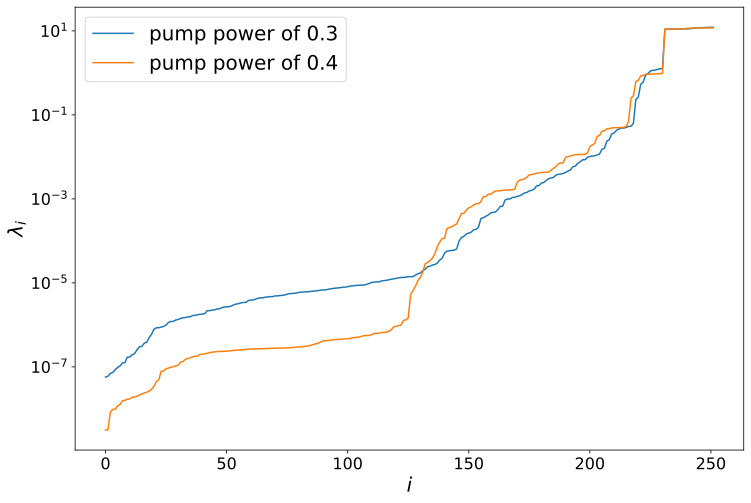

In [6]:
plt.figure(figsize = (12, 8))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel(r"$i$", fontsize = 20)
plt.ylabel(r"$\lambda _i$", fontsize = 20)
plt.semilogy(eig_val, label = "pump power of 0.3")
plt.semilogy(eig_val_2, label = "pump power of 0.4")
plt.legend(fontsize = 20)
#plt.savefig("pres_eigvals.png")
print("e")

In [ ]:
# beta_weight 0.2 with 10th order with width of 2, unfeasible

In [ ]:
# Try to get the pump for different values of beta_weight

In [38]:
# 1.27 when fix the pump, the difference is 1.52 - 1.27... let's see difference between the theoretical pump and optimized when no fix pump constraints when n = 0.5
# when n = 0.0001, theoretical is 1.567, optimal is 1.314
# When n = 1., theoretical is 1.494, optimal is 1.248
# When n = 0.2, theoretical is 1.548, optimal is 1.295
# When n = 0.3, theoretical is 1.539, optimal is 1.287
0.5*sum(scipy.linalg.svd(W_plus[-1] - W_minus[-1])[1])

1.539123699272878

In [69]:
np.trace(opt_pump@opt_pump)

(0.4875503736384507-2.4434131339694572e-12j)

In [59]:
herm_coeff = hermite_coeff.value

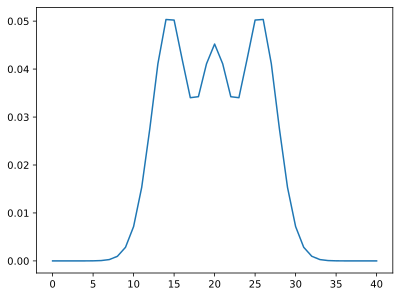

In [60]:
# plot at 150 beta_weight
plt.plot(hermite_mat.T@herm_coeff)

In [18]:
sum(0.5*scipy.linalg.svd(W_plus[-1]  - W_minus[-1])[1])

1.4254369573046808

In [ ]:
# Maybe bc gain not big enough?
# When just constraining on first and last row, it still has strong duality. Wonder if i remove rows one by one what happens?

In [3]:
end_product = np.load("pert_beta_weight_0_02531_nuc_norm_constr_hermite_basis.npy")#np.load("n_1_beta_weight_5_l_0_point_1.npy")#variable.value#np.load("n_1_fix_pump_small_margin.npy")#variable.value#
U_plus = [end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z - 1)]
U_minus = [end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (N_z - 1 + i)*N_omega:(N_z + i)*N_omega] for i in range(N_z - 1)]
VU_plus = [end_product[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z - 1)]
VU_minus = [end_product[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, (N_z - 1 + i)*N_omega:(N_z + i)*N_omega] for i in range(N_z - 1)]
quad_U_plus = [end_product[i*N_omega:(i + 1)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z - 1)]
quad_U_minus = [end_product[(N_z - 1 + i)*N_omega:(N_z + i)*N_omega, (N_z - 1 + i)*N_omega:(N_z + i)*N_omega] for i in range(N_z - 1)]
pump_U_plus = [end_product[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z - 1)]
pump_U_minus = [end_product[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, (N_z - 1 + i)*N_omega:(N_z - 1 + i + 1)*N_omega] for i in range(N_z - 1)]
opt_pump = end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega]

In [4]:
sum(scipy.linalg.svd(U_plus[-1] - U_minus[-1])[1])

2.444599831862797

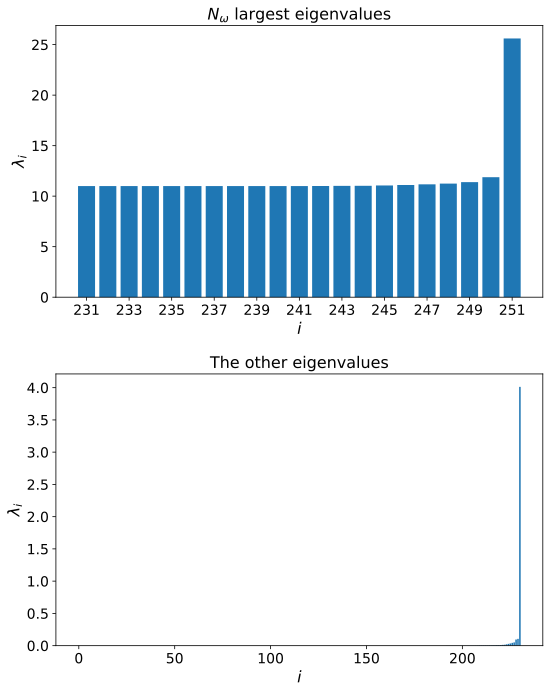

In [32]:
# Eigenvalues of solution of SDR
import matplotlib

matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

fig, axs = plt.subplots(2)
fig.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(8)
axs[0].set_title(r"$N_\omega$ largest eigenvalues", fontsize = 16)
axs[0].set_xlabel(r"$i$", fontsize = 16)
axs[0].set_ylabel(r"$\lambda _i$", fontsize = 16)
axs[0].set_xticks(np.arange((2*N_z - 1)*N_omega, 2*N_z*N_omega, 2))
axs[0].bar(x = np.arange((2*N_z - 1)*N_omega, 2*N_z*N_omega), height = np.linalg.eigvalsh(end_product)[-N_omega:])
axs[1].set_title(r"The other eigenvalues", fontsize = 16)
axs[1].set_xlabel(r"$i$", fontsize = 16)
axs[1].set_ylabel(r"$\lambda _i$", fontsize = 16)
axs[1].bar(x = np.arange((2*N_z - 1)*N_omega), height = np.linalg.eigvalsh(end_product)[:-N_omega])
plt.savefig("largest_eigenvalues_pert_regime.pdf")

In [28]:
# Verify central finite difference
coeffs = findiff.coefficients(deriv = 1, offsets=list(np.arange(-N_z + 1, 0)) + list(np.arange(1, N_z )))["coefficients"]
approx = sum([(coeffs[i + N_z - 1]/delta_z)*U_plus[i].conj().T for i in range(len(W_plus))]) - sum([(coeffs[i + N_z - 1]/delta_z)*U_minus[i] for i in range(len(W_minus))])
true = (1/np.sqrt(n))*(delta_k + beta_weight*opt_pump)

In [29]:
np.max(np.abs(np.real(approx - true))),np.max(np.abs(np.imag(approx - true)))

(2.0436580899785284e-09, 1.2396564230243712e-05)

In [8]:
proj = projections[0]
coeffs = findiff.coefficients(deriv = 1, offsets=list(np.arange(-N_z + 1, 0)) + list(np.arange(1, N_z )))["coefficients"][N_z - 1:]
lin_pump = beta_weight*(1/np.sqrt(n))*api.get_lin_matrices(N_omega = N_omega, N_z = N_z, proj = proj)[-1]
lin_plus = (1/delta_z)*sum([api.get_lin_matrices(N_omega = N_omega, N_z = N_z, proj = -coeffs[i]*proj)[i] for i in range(len(coeffs))])
lin_minus = (1/delta_z)*sum([api.get_lin_matrices(N_omega = N_omega, N_z = N_z, proj = coeffs[i]*proj.conj().T)[N_z - 1 + i] for i in range(len(coeffs))])
lin_real = lin_pump + lin_plus + lin_minus
lin_imag = 1.j*(lin_pump + lin_plus - lin_minus)
cst = (1/np.sqrt(n))*np.trace(proj@delta_k)
mat_real = sparse.bmat([[sparse.csc_matrix(((2*N_z - 1)*N_omega,(2*N_z - 1)*N_omega)), 0.5*lin_real],
                        [0.5*lin_real.conj().T, sparse.csc_matrix((N_omega, N_omega))]])
mat_imag = sparse.bmat([[sparse.csc_matrix(((2*N_z - 1)*N_omega,(2*N_z - 1)*N_omega)), 0.5*lin_imag],
                        [0.5*lin_imag.conj().T, np.imag((cst/N_omega))*sparse.eye(N_omega)]])

In [9]:
np.trace(mat_real@Y@Y.conj().T)

(6.217248937900877e-15+0j)

In [30]:
# Verify the dynamics for plus for optimal solution
green_f = api.get_green_f(omega, z[1:-1])
green_f.reverse()
first_term = scipy.linalg.expm(delta_k*z[-1]).conj().T
second_term = 0.5*delta_z*beta_weight*((np.sqrt(n))*VU_plus[-1] + scipy.linalg.expm(delta_k*z[-1]).conj().T@opt_pump)
third_term = (np.sqrt(n))*delta_z*beta_weight*sum([green_f[i].conj().T@VU_plus[i] for i in range(len(green_f))])
approx = first_term + second_term + third_term

In [31]:
np.max(np.abs(np.real((1/np.sqrt(n))*approx - U_plus[-1]))), np.max(np.abs(np.imag((1/np.sqrt(n))*approx - U_plus[-1])))

(1.2419071433455997e-06, 1.0445043692186573e-06)

In [32]:
# Verify the dynamics for minus for optimal solution
green_f = api.get_green_f(omega, z[1:-1])
green_f.reverse()
first_term = scipy.linalg.expm(delta_k*z[-1]).conj().T
second_term = -(0.5*delta_z*beta_weight*((np.sqrt(n))*VU_minus[-1] + scipy.linalg.expm(delta_k*z[-1]).conj().T@opt_pump))
third_term = -(np.sqrt(n))*delta_z*beta_weight*sum([green_f[i].conj().T@VU_minus[i] for i in range(len(green_f))])
approx = first_term + second_term + third_term

In [33]:
np.max(np.abs(np.real((1/np.sqrt(n))*approx - U_minus[-1]))), np.max(np.abs(np.imag((1/np.sqrt(n))*approx - U_minus[-1])))

(1.2383169611940303e-06, 1.0422128491338611e-06)

In [34]:
# Verify the finite differences for plus for optimal solution
coeffs = findiff.coefficients(deriv = 1, offsets=list(np.arange(0, N_z)))["coefficients"]
j = 4
quad_plus = [end_product[i*N_omega:(i + 1)*N_omega, j*N_omega:(j + 1)*N_omega] for i in range(N_z - 1)]
quad_pump_prop = end_product[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, j*N_omega:(j + 1)*N_omega]
truth = (1/np.sqrt(n))*(delta_k@U_plus[j] + beta_weight*quad_pump_prop)
test = sum([(1/delta_z)*coeffs[i + 1]*quad_plus[i] for i in range(len(W_plus))]) + (coeffs[0]/(delta_z*np.sqrt(n)))*U_plus[j]

In [35]:
np.max(np.abs(np.real(truth - test))), np.max(np.abs(np.imag(truth - test)))

(5.402567282430937e-12, 7.633893517322576e-12)

In [27]:
# Verify the finite differences for minus for optimal solution
# The case for U_minus is not right...
coeffs = findiff.coefficients(deriv = 1, offsets=list(np.arange(0, N_z)))["coefficients"]
j = 4
quad_minus = [end_product[(N_z - 1 + i)*N_omega:(N_z - 1 + i + 1)*N_omega, (N_z - 1 + j)*N_omega:(N_z - 1 + j + 1)*N_omega] for i in range(N_z - 1)]
quad_pump_prop = end_product[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, (N_z - 1 + j)*N_omega:(N_z - 1 + j + 1)*N_omega]
truth = (1/np.sqrt(n))*(delta_k@U_minus[j] - beta_weight*quad_pump_prop)
test = (sum([(1/delta_z)*coeffs[i + 1]*quad_minus[i] for i in range(len(W_minus))]) + (coeffs[0]/(delta_z*np.sqrt(n)))*np.eye(N_omega)@U_minus[j])

In [28]:
np.max(np.abs(np.real(truth - test))), np.max(np.abs(np.imag(truth - test)))

(1.1657341758564144e-13, 5.595524044110789e-14)

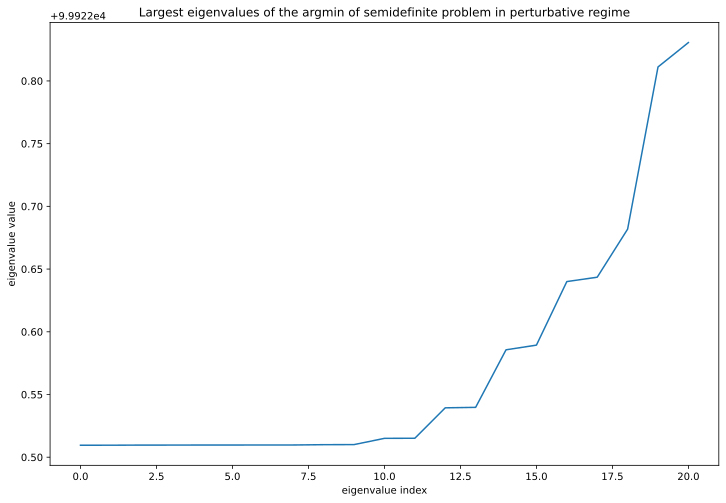

In [25]:
plt.figure(figsize = (12, 8))
plt.title("Largest eigenvalues of the argmin of semidefinite problem in perturbative regime")
plt.xlabel("eigenvalue index")
plt.ylabel("eigenvalue value")
plt.plot(scipy.linalg.eigvalsh(end_product)[(2*N_z - 1)*N_omega:])
#plt.savefig("largest_eigenvalues_pert_regime.png")

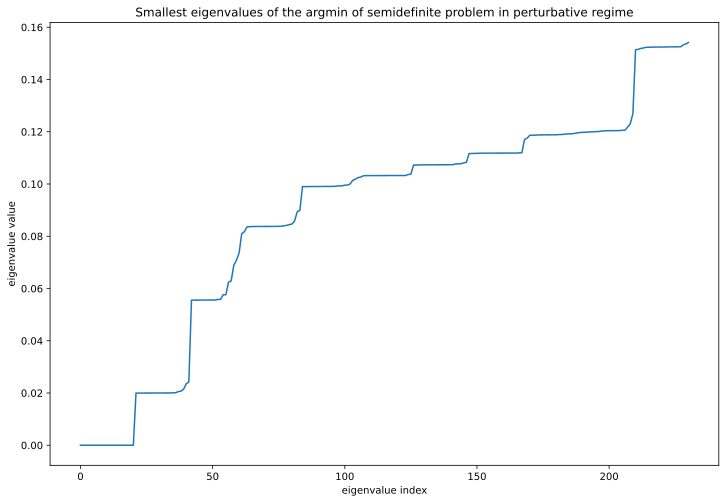

In [26]:
plt.figure(figsize = (12, 8))
plt.title("Smallest eigenvalues of the argmin of semidefinite problem in perturbative regime")
plt.xlabel("eigenvalue index")
plt.ylabel("eigenvalue value")
plt.plot(scipy.linalg.eigvalsh(end_product)[:(2*N_z - 1)*N_omega])
#plt.savefig("smalles_eigenvalues_pert_regime.png")

In [16]:
coeffs = (1/(2520*delta_z))*np.array([2100., -600., 150., -25., 2])
approx = (np.sqrt(n))*sum([W_plus[i]*coeffs[i] - W_minus[i].conj().T*coeffs[i] for i in range(len(coeffs))])
np.max(np.abs(np.real(approx.conj() - (delta_k + beta_weight*opt_pump)))), np.max(np.abs(np.imag(approx - (delta_k + beta_weight*opt_pump))))

(0.016890603509142926, 0.8844518669279182)

In [29]:
np.trace(opt_pump)

(-0.0005808038541557538+1.8483157323250136e-13j)

In [33]:
(0.5/np.sqrt(n))*sum(scipy.linalg.svd(U_plus[-1] - U_minus[-1])[1])

(0.8196254130195658+0j)

In [30]:
np.trace((opt_pump + 0.022*np.eye(N_omega))@(opt_pump + 0.022*np.eye(N_omega))), np.trace(new_beta@new_beta)

((0.9988023423586574+3.7268386004502043e-13j), 1.0)

In [34]:
theor_U_plus = scipy.linalg.expm(delta_k + beta_weight*opt_pump)
theor_U_minus = scipy.linalg.expm(delta_k - beta_weight*opt_pump)

In [35]:
n_test = 0.25*np.trace((theor_U_plus - theor_U_minus)@(theor_U_plus - theor_U_minus).conj().T)
sum((0.5/np.sqrt(n))*scipy.linalg.svd(theor_U_plus - theor_U_minus)[1])

(1.4710983949387446+0j)

In [77]:
np.max(np.abs(np.real(U_plus[-1] - W_plus[-1].conj()))), np.max(np.abs(np.imag(U_plus[-1] - W_plus[-1].conj())))

(0.028036748136119914, 0.018492424053776567)

In [82]:
np.max(np.abs(np.real(U_plus[-1] - W_plus[-1].conj()))), np.max(np.abs(np.imag(U_plus[-1] - W_plus[-1].conj())))

(0.05375063827741611, 0.033630696502624124)

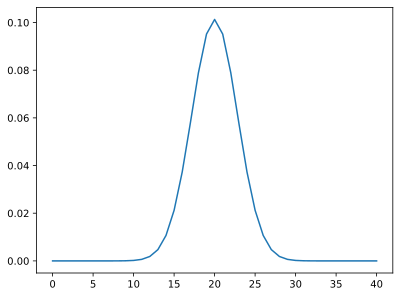

In [75]:
plt.plot(list(opt_pump[0]) + list(opt_pump[-1][1:]))

In [84]:
np.save("n_1_fix_pump_N_z_5.npy", end_product)

In [ ]:
# beta_weight = 0.3, n with optimal pump is 0.00285

In [29]:
test_plus = scipy.linalg.expm(delta_k + beta_weight*opt_pump)
test_minus = scipy.linalg.expm(delta_k - beta_weight*opt_pump)
0.25*np.trace((test_plus - test_minus)@(test_plus - test_minus.conj().T))

(0.002848200185926106+3.931354481149715e-08j)

In [21]:
# Compare the matrix exponential of the optimal pump with the optimal value 
# n = 1, theoretical obj f is 1.493, optimized is 0.820
# What if i plug the optimal pump from previous and fix it exactly?
test_U_plus = scipy.linalg.expm(delta_k + beta_weight*opt_pump)
test_U_minus = scipy.linalg.expm(delta_k - beta_weight*opt_pump)
0.5*sum(scipy.linalg.svd(W_plus[-1] - W_minus[-1])[1]), 0.5*sum(scipy.linalg.svd(U_plus[-1] - U_minus[-1])[1])

(1.4939067156878945, 0.8196642788124197)

In [30]:
scipy.linalg.svd(W_minus[-1] + W_minus[-1].conj().T)[1]

array([2.78200586, 2.76586926, 2.73289515, 2.68774372, 2.59150353,
       2.57446054, 2.54878046, 2.40397965, 2.35441371, 2.19440044,
       2.10864365, 1.97518503, 1.80515321, 1.76168987, 1.25213965,
       1.04407965, 0.8935417 , 0.84569234, 0.67865535, 0.44674697,
       0.33253656])

In [28]:
np.max(np.abs(np.real(W_plus[-1] - U_plus[-1].conj()))), np.max(np.abs(np.imag(W_plus[-1] - U_plus[-1].conj())))

(0.11549974674214414, 0.05475363066948044)

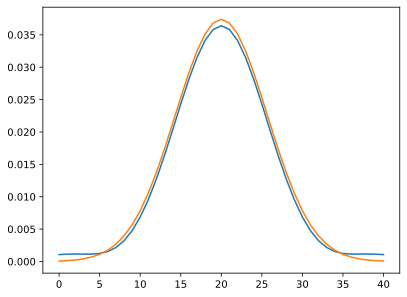

In [31]:
plt.plot(list(opt_pump[0]) + list(opt_pump[-1][1:]))
plt.plot(list(new_beta[0]) + list(new_beta[-1][1:]))

In [136]:
# Constraints on the determinant?
test = -0.2*scipy.special.hermite(0)(np.linspace(omega[0], omega[-1], 2*N_omega - 1))*np.exp(-np.linspace(omega[0], omega[-1], 2*N_omega - 1)**2)
U_test_plus = scipy.linalg.expm(delta_k + scipy.linalg.hankel(test[:N_omega], test[N_omega - 1:]))
U_test_minus = scipy.linalg.expm(delta_k - scipy.linalg.hankel(test[:N_omega], test[N_omega - 1:]))
n = 0.25*np.trace((U_test_plus - U_test_minus)@(U_test_plus - U_test_minus).conj().T)
sum((0.5/np.sqrt(n))*(scipy.linalg.svd(U_test_plus - U_test_minus)[1])), n, np.linalg.det(U_test_plus), np.linalg.det(U_test_minus)

((1.5961402573362538+0j),
 (1.8012960486460092+0j),
 (0.4921451723002729-5.463909017458775e-17j),
 (2.0319207751770243-2.255885228815729e-15j))

In [153]:
np.max(W_plus[-1] - W_minus[-1]) - np.min(W_plus[-1] - W_minus[-1]), np.max(U_plus[-1] - U_minus[-1]) - np.min(U_plus[-1] - U_minus[-1])

((0.45227234181882014+0.03112140244129576j),
 (6.019829789814454e-12+1.0387182640685962e-13j))

In [135]:
scipy.linalg.det(U_plus[-1]),scipy.linalg.det(U_minus[-1])

((2258.7789996815204+2.8628040809053346e-06j),
 (2258.778999590362+2.862803512471146e-06j))

In [41]:
0.5*sum(scipy.linalg.svd(U_plus[-1] - U_minus[-1])[1]), 0.5*sum(scipy.linalg.svd(U_plus[-1])[1]), 0.5*sum(scipy.linalg.svd(U_minus[-1])[1]), 0.5*cst_plus, 0.5*cst_minus

(3.474357394588633e-11,
 15.166929124667364,
 15.166929124638216,
 (16.19141576972067+0j),
 (15.19251827214253+0j))

In [78]:
np.max(scipy.linalg.svd(U_plus[-1])[1]), np.max(scipy.linalg.svd(U_minus[-1])[1]), 1 + np.sqrt(1 + 1/0.5), np.sqrt(1/n)

(1.4460310305110002,
 1.4460310305075028,
 2.732050807568877,
 (1.4795993003745025+0j))

In [23]:
theoretical_plus = (1/np.sqrt(n))*scipy.linalg.expm((delta_k + beta_weight*opt_pump)*z[-1])
theoretical_minus = (1/np.sqrt(n))*scipy.linalg.expm((delta_k - beta_weight*opt_pump)*z[-1])
np.trace(theoretical_plus@theoretical_plus.conj().T + theoretical_minus@theoretical_minus.conj().T - (2/n)*np.eye(N_omega)) 

(0.5680012112834447+0j)

In [25]:
np.max(np.abs(np.imag(theoretical_plus - U_plus[4].conj())))

0.0013296889175258286

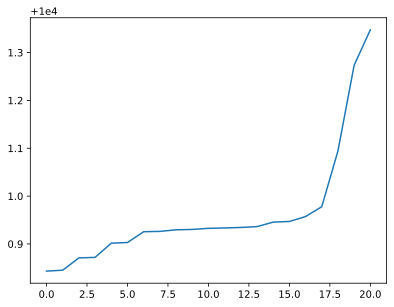

In [26]:
# Last N_omega eigenvalues
plt.plot(scipy.linalg.eigvalsh(end_product)[(2*N_z - 1)*N_omega:])

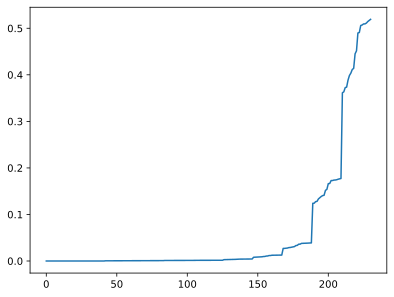

In [27]:
# Number of eigenvalues before last N_omega
plt.plot(scipy.linalg.eigvalsh(end_product)[:(2*N_z - 1)*N_omega])

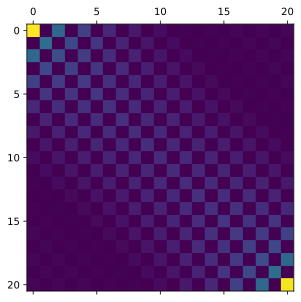

In [31]:
# JSA
plt.matshow(np.abs((U_plus[-1] + U_minus[-1]).conj().T@(U_plus[-1] - U_minus[-1])))

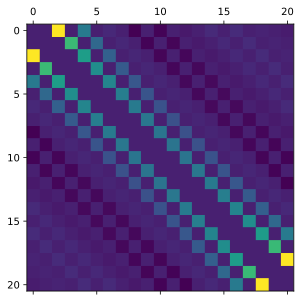

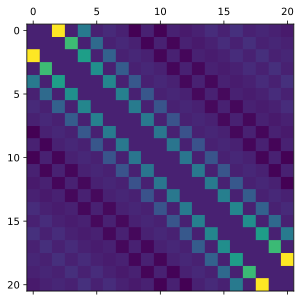

In [28]:
# U_+ U_+ dagger for the optimized result and U_+ U_+ dagger for the result from matrix exponentiation with linear part of pump
test = (1/n)*scipy.linalg.expm((delta_k + beta_weight*opt_pump)*z[-1])@scipy.linalg.expm((delta_k + beta_weight*opt_pump)*z[-1]).conj().T
plt.matshow(np.real(quad_U_plus[4] - np.diag(np.diag(quad_U_plus[4]))))
plt.matshow(np.real(test - np.diag(np.diag(test))))

In [54]:
left_X = np.vstack([np.zeros((5,5)), np.eye(5)])
right_X = np.vstack([np.eye(5), np.zeros((5, 5))])
X = cp.Variable(shape = (10, 10))
constraints = [cp.bmat([[np.eye(5), left_X.conj().T@X@right_X],[right_X.conj().T@X.conj().T@left_X, np.eye(5)]]) << 0]
constraints.append(X >> 0)
problem = cp.Problem(cp.Maximize(0.), constraints)
problem.is_dcp()

True

/home/jiaqizhao/miniconda3/envs/cvxpy_opt/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


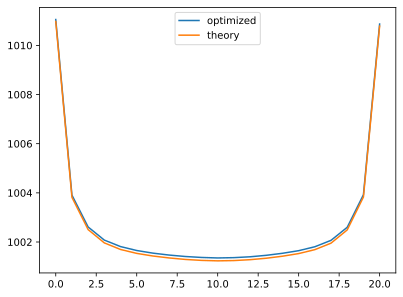

In [29]:
# All about U_+ U_+ dagger
plt.plot(np.diag(quad_U_plus[4]), label = "optimized")
plt.plot(np.diag(test), label = "theory")
plt.legend()

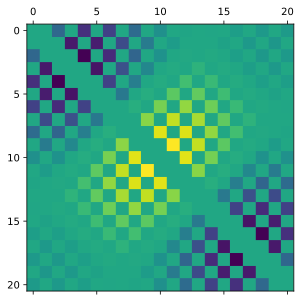

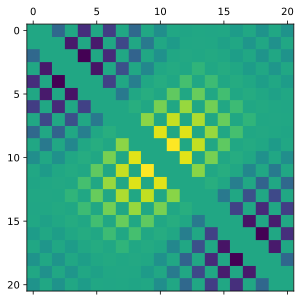

In [30]:
# U_+ dagger for the optimized result and U_+ U_+ dagger for the result from matrix exponentiation with linear part of pump
test = (1/np.sqrt(n))*scipy.linalg.expm((delta_k + beta_weight*opt_pump)*z[-1]).conj().T
plt.matshow(np.real(U_plus[4] - np.diag(np.diag(U_plus[4]))))
plt.matshow(np.real(test - np.diag(np.diag(test))))

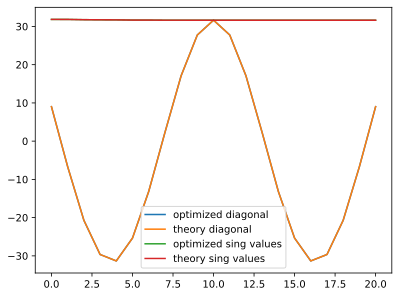

In [33]:
# All about U_+ dagger
plt.plot(np.diag(U_plus[4]), label = "optimized diagonal")
plt.plot(np.diag(test), label = "theory diagonal")
plt.plot(scipy.linalg.svd(U_plus[4])[1], label = "optimized sing values")
plt.plot(scipy.linalg.svd(test)[1], label = "theory sing values")
plt.legend()

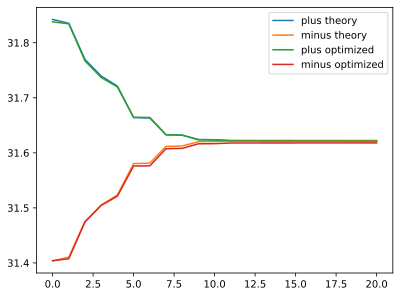

In [34]:
# Singular values of U_+ and U_-, optimized and theoretical
theory_U_plus = (1/np.sqrt(n))*scipy.linalg.expm((delta_k + beta_weight*opt_pump)*z[-1])
theory_U_minus = (1/np.sqrt(n))*scipy.linalg.expm((delta_k - beta_weight*opt_pump)*z[-1])
plt.plot(scipy.linalg.svd(theory_U_plus)[1], label = "plus theory")
plt.plot(np.sort(scipy.linalg.svd(theory_U_minus)[1]), label = "minus theory")
plt.plot(scipy.linalg.svd(U_plus[4])[1], label = "plus optimized")
plt.plot(np.sort(scipy.linalg.svd(U_minus[4])[1]), label = "minus optimized")
plt.legend()

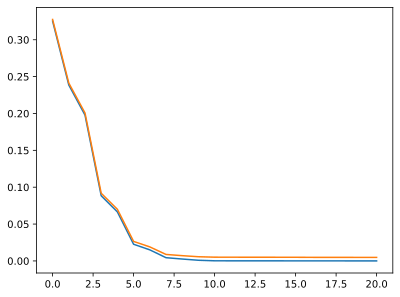

In [25]:
# Singular values of the difference between the exponential and the optimized between U_+ and U_-
plt.plot(scipy.linalg.svd(theory_U_plus - theory_U_minus)[1], label = "plus theory")
plt.plot(scipy.linalg.svd(U_plus[4] - U_minus[4])[1], label = "plus theory")

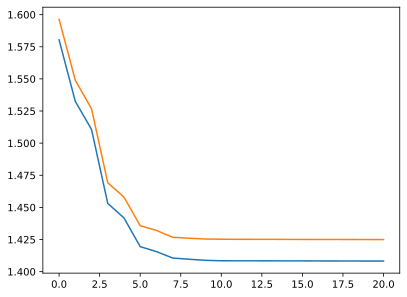

In [34]:
# Are the symplectic constraints on individual U_plus and U_minus satisfied?
liste = list((1/0.5)*(1/scipy.linalg.svd(U_minus[4])[1]))
liste.reverse()
plt.plot(scipy.linalg.svd(U_plus[4])[1])
plt.plot(np.array(liste))

In [38]:
np.max(np.abs(np.imag(U_minus[4]@U_plus[4].conj().T - np.diag(np.diag(U_minus[4]@U_plus[4].conj().T )))))

3.2796895951125874e-06

In [26]:
0.25*np.trace((U_plus[4] - U_minus[4])@(U_plus[4] - U_minus[4]).conj().T)

(0.05515083060749958+0j)

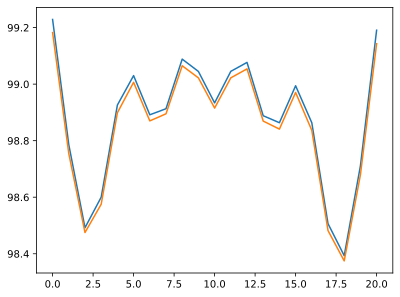

In [49]:
plt.plot(np.diag(quad_U_minus[4]))
plt.plot(np.diag(U_minus[4]@U_minus[4].conj().T))

In [67]:
# Froebenius norm of difference between U_+ U_+ dagger and U_+ multiplied by U_+ dagger
np.sqrt(np.trace((U_plus[4]@U_plus[4].conj().T - quad_U_plus[4])@(U_plus[4]@U_plus[4].conj().T - quad_U_plus[4]).conj().T))

(0.1805496345421285+0j)

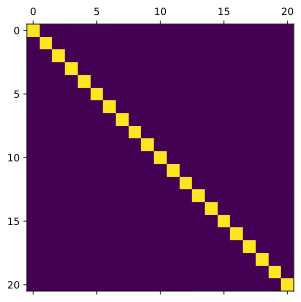

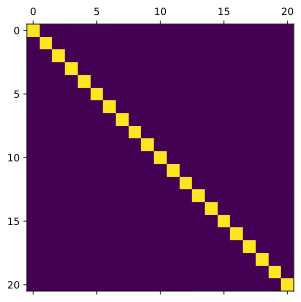

In [50]:
# Compare U_plus and U_plus dagger with U_+U_+ dagger
plt.matshow(np.real(quad_U_plus[4]))
plt.matshow(np.real(U_plus[4]@U_plus[4].conj().T))

/home/jiaqizhao/miniconda3/envs/cvxpy_opt/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


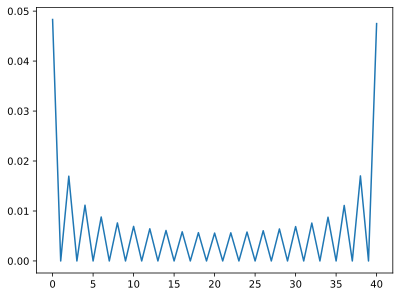

In [32]:
plt.plot(list(opt_pump[0]) + list(opt_pump[-1][1:]))

In [22]:
d_minus = scipy.linalg.svd(end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (2*N_z - 3)*N_omega:(2*N_z - 2)*N_omega])[1]
d_plus = scipy.linalg.svd(end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (N_z - 1)*N_omega:N_z*N_omega])[1]
d_minus_theory = scipy.linalg.svd(W_minus[-1])[1]
d_plus_theory = scipy.linalg.svd(W_plus[-1])[1]

In [40]:
np.max(scipy.linalg.svd(U_plus[-1])[1]), (1 + np.sqrt(1 + 1/n)), np.max(scipy.linalg.svd(U_minus[-1])[1]), (0.1 + np.sqrt(0.1 + 1/n))

(31.837982723559534,
 (32.63803991792345+0j),
 31.618056316645724,
 (31.723813335018875+0j))

In [47]:
0.25*(scipy.linalg.eigvalsh((U_plus[-1] - U_minus[-1])@(U_plus[-1] - U_minus[-1]).conj().T))

array([2.78094530e-06, 2.80315649e-06, 2.83227722e-06, 2.88576247e-06,
       2.89226586e-06, 2.93618090e-06, 3.02079933e-06, 3.04310429e-06,
       3.43075247e-06, 3.50882859e-06, 1.07869299e-05, 1.30049108e-05,
       1.44891563e-04, 1.61735526e-04, 1.93450409e-03, 1.95769062e-03,
       9.84665249e-03, 1.34912249e-02, 2.13939703e-02, 4.55487461e-02,
       4.70684570e-02])

In [50]:
0.25*scipy.linalg.eigvalsh((W_plus[-1] - W_minus[-1])@(W_plus[-1] - W_minus[-1]).conj().T)

array([-7.82524297e-17, -5.74502620e-17, -1.03011734e-17, -4.26196487e-18,
        2.88156058e-18,  8.00277936e-18,  2.81596416e-17,  4.14421407e-17,
        1.29189115e-16,  1.73538156e-15,  2.56699355e-12,  8.87577488e-10,
        3.35940429e-09,  1.58000119e-07,  9.72532800e-07,  1.35403853e-06,
        3.10593343e-04,  1.50126816e-02,  1.59528211e-02,  3.63952947e-02,
        9.32326120e-01])